In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import math
import time
import random
import networkx as nx
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import copy
import community
import umap
from sklearn.manifold import TSNE

/home/dexu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-11 00:30:31.473086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 00:30:31.759342: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 00:30:32.924833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_lo

In [180]:
class Args():
    def __init__(self) -> None:
        self.dataset = 'cora'
        self.model = 'GAE'

        self.input_dim = 200  # featrues
        self.encoded_space_dim = 50
        self.n_cluster = 5  # clusters
        self.use_feature = False

        self.num_epoch = 500
        self.learning_rate = 0.01
        self.start_mf = 300
        self.LAMBDA = 0.01
args = Args()

In [181]:
def TSNE_visualize(epoch, encoded, color="k", centroids=None):
    reducer = TSNE(n_components=2,random_state=33,init="pca",learning_rate="auto")
    embedding_all = reducer.fit_transform(np.vstack((encoded,centroids)))    # centroids = reducer.fit_transform(centroids)
    fig = plt.figure(figsize = (5,5))
    if centroids is not None:
        centroids = embedding_all[-len(centroids):]
        plt.scatter(centroids[:, 0], centroids[:, 1], c="k", marker="*")
        embedding = embedding_all[:-len(centroids)]
        plt.scatter(embedding[:, 0], embedding[:, 1], c=color, s=20)
    else:
        embedding = embedding_all
        plt.scatter(embedding[:, 0], embedding[:, 1], c=color, s=20)

    plt.title('TSNE projection of the dataset')
    plt.show()
def umap_visualize(epoch, encoded, color="k", centroids=None):
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(encoded)
    fig = plt.figure(figsize = (5,5))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=color, s=20)
    if centroids is not None:
        centroids = reducer.transform(centroids)
        plt.scatter(centroids[:, 0], centroids[:, 1], c="k", marker="*")
    plt.title('UMAP projection of the dataset')
    plt.show()

In [182]:
def dot_product_decode(Z):
    return torch.sigmoid(torch.matmul(Z, Z.t()))


def glorot_init(input_dim, output_dim):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = torch.rand(input_dim, output_dim) * 2 * init_range - init_range
    return nn.Parameter(initial,requires_grad=True)


class GraphConvSparse(nn.Module):
    def __init__(self, input_dim, output_dim, adj, activation=F.leaky_relu, **kwargs):
        super(GraphConvSparse, self).__init__(**kwargs)
        self.weight = glorot_init(input_dim, output_dim)  # m k
        self.adj = adj
        self.activation = activation

    def forward(self, inputs):
        x = inputs
        x = torch.mm(x, self.weight)
        x = torch.mm(self.adj, x)
        outputs = self.activation(x)
        return outputs


class GAE(nn.Module):
    def __init__(self, adj):
        super(GAE, self).__init__()
        # nodes * features --> m * n
        self.base_gcn = GraphConvSparse(args.input_dim, args.encoded_space_dim, adj)
        self.cluster_centroid = glorot_init(args.n_cluster, args.encoded_space_dim)

    @staticmethod
    def normalize(X):
        X_std = (X - X.min(dim=1).values[:,None])/(X.max(dim=1).values - X.min(dim=1).values)[:,None]
        return X_std / torch.sum(X_std,dim=1)[:,None]

    def encode(self, _X):
        hidden_z = self.base_gcn(_X)  # m n
        hidden_z = torch.nn.functional.normalize(hidden_z,p=2,dim=1)
        return hidden_z

    def forward(self, _input, _epoch):
        z = self.encode(_input)
        # z = torch.nn.functional.normalize(self.encode(_input),dim=1)
        A_pred = dot_product_decode(z)
        if _epoch > args.start_mf:
            pinv_weight = torch.linalg.pinv(self.cluster_centroid)  # compute pesudo inverse of W [ n * k ]

            indicator = self.normalize(torch.mm(z, pinv_weight))  # m * n --> m * k
            # indicator = torch.softmax(torch.mm(z, pinv_weight),dim=1)  # m * n --> m * k

            return A_pred, z, indicator
        else:
            return A_pred, z, None

In [175]:
import scipy.sparse as sp

def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)

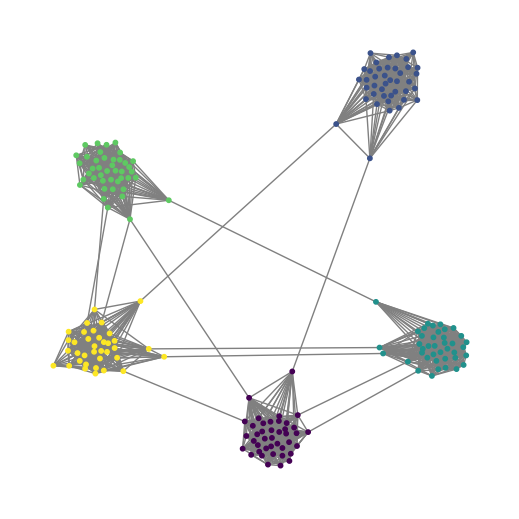

In [179]:
from itertools import combinations
import networkx as nx
# node_labels = {0:"Mr. Hi", 33:"John A."}

g = nx.gaussian_random_partition_graph(200, 40, 40, 0.5, 0.001)
partition = g.graph["partition"]
clusters = np.concatenate([[com]*len(cset) for com,cset in enumerate(partition)],axis=0)
# Plot the graph
G_layout = g.copy()
layout = nx.spring_layout(G_layout, seed=17)
del G_layout
plt.figure(figsize=(5,5)) 
nx.draw(g, layout, node_color=clusters, node_size=10, edge_color="gray")

In [183]:
adj = sp.coo_matrix(nx.adjacency_matrix(g))
features = sp.coo_matrix(np.eye(adj.shape[0]), dtype=np.int64)  # use one hot as features
features = sparse_to_tuple(features.tocoo())
features = torch.sparse.FloatTensor(torch.LongTensor(features[0].T),
                                        torch.FloatTensor(features[1]),
                                        torch.Size(features[2]))

/tmp/ipykernel_4479/590588730.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = sp.coo_matrix(nx.adjacency_matrix(g))


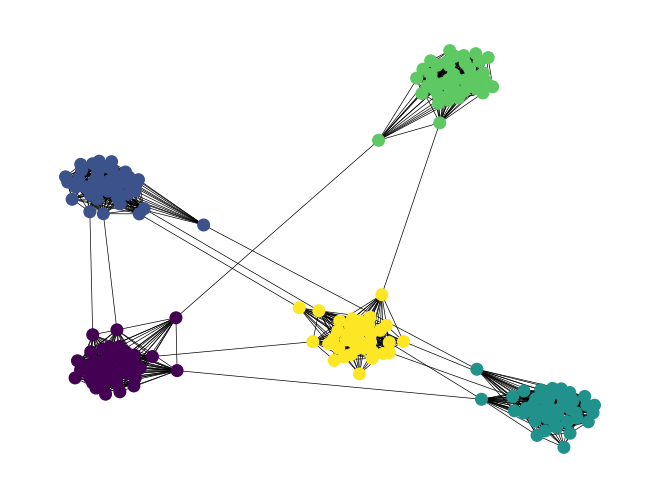

In [184]:
def louvain(graph):
    sc_com = community.best_partition(graph, weight='weight')
    return sc_com
com = louvain(g)

def visualization(G,sc_com):
    _com = [0 for i in range(len(sc_com.keys()))]
    count = 0
    for _,v in sc_com.items():
        _com[count] = v
        count += 1
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=70, width=0.5, node_color=_com)
    plt.show()
visualization(g,com)

In [185]:
import seaborn as sn
from sklearn.cluster import KMeans


def print_results(c, y, n_clusters=10):
    y_train_to_clustered = np.dstack([y, c])[0]
    clustered_tallies = np.zeros((n_clusters, n_clusters), dtype=int)
    for i in range(0, len(y_train_to_clustered)):
        clustered_tallies[y_train_to_clustered[i][1]][y_train_to_clustered[i][0]] += 1

    cluster_to_num_map = list(map(lambda x: np.argmax(x), clustered_tallies))
    clustered_tallies = sorted(clustered_tallies, key=lambda e: np.argmax(e))

    fig, ax = plt.subplots(1, figsize=(5, 5))
    p = sn.heatmap(clustered_tallies, annot=True, fmt="d", annot_kws={"size": 10}, cmap='coolwarm', ax=ax, square=True,
                   yticklabels=cluster_to_num_map)
    plt.xlabel('Actual')
    plt.ylabel('Cluster')
    p.tick_params(length=0)
    p.xaxis.tick_top()
    p.xaxis.set_label_position('top')
    plt.title('Cluster match count for each number')

    # purity - sum of correct in each class divided by the total number of images
    purity_sums = np.zeros((10, 1))

    for i in range(0, len(y_train_to_clustered[:])):
        if cluster_to_num_map[y_train_to_clustered[i][1]] == y[i]:
            purity_sums[cluster_to_num_map[y_train_to_clustered[i][0]]] += 1

    print('Purity ', np.add.reduce(purity_sums)[0] / len(y))
    plt.show()


def kmeans(encoded_z, labels, indicators, n_clusters=7):
    k_encoded = KMeans(n_clusters=n_clusters)
    # Evaluate cluster
    z = encoded_z.cpu().detach()
    k_encoded.fit(z)
    print_results(k_encoded.labels_, labels, n_clusters=n_clusters)
    print_results(indicators.argmax(axis=1).cpu().detach(), labels, n_clusters=n_clusters)



In [186]:
def get_acc(adj_rec, adj_label):
    labels_all = adj_label.to_dense().view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    return (preds_all == labels_all).sum().float() / labels_all.size(0)

def train(features,adj):
    adj_norm = preprocess_graph(adj) # norm
    adj_label = sparse_to_tuple(adj)

    adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                        torch.FloatTensor(adj_norm[1]),
                                        torch.Size(adj_norm[2]))
    adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                        torch.FloatTensor(adj_label[1]),
                                        torch.Size(adj_label[2]))


    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    weight_mask = adj_label.to_dense().view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0))
    weight_tensor[weight_mask] = pos_weight

    # prepare model 
    model = GAE(adj_norm)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # train model
    for epoch in range(args.num_epoch):
        t = time.time()

        A_pred, encoded_z, dict_s = model(features, epoch)
        optimizer.zero_grad()
        loss_gae = norm * F.binary_cross_entropy(A_pred.view(-1),
                                                 adj_label.to_dense().view(-1),
                                                 weight=weight_tensor)
        loss_cm = torch.nn.MSELoss()
        if epoch > args.start_mf:
            # print(encoded_z)
            loss_kmeans = loss_cm(encoded_z, torch.mm(dict_s, model.cluster_centroid))
            loss = loss_gae + 1 * loss_kmeans
        else:
            loss = loss_gae
            loss_kmeans = loss

        loss.backward()
        optimizer.step()

        train_acc = get_acc(A_pred, adj_label)
        print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss.item()),
            "mf_loss=", "{:.5f}".format(loss_kmeans.item()),
            "train_acc=", "{:.5f}".format(train_acc), "time=", "{:.5f}".format(time.time() - t))

    kmeans(encoded_z, labels=clusters, indicators=dict_s, n_clusters=args.n_cluster)
    return model

Epoch: 0001 train_loss= 0.66057 mf_loss= 0.66057 train_acc= 0.09700 time= 0.03203
Epoch: 0002 train_loss= 0.60333 mf_loss= 0.60333 train_acc= 0.10020 time= 0.01237
Epoch: 0003 train_loss= 0.57325 mf_loss= 0.57325 train_acc= 0.19945 time= 0.00309
Epoch: 0004 train_loss= 0.55902 mf_loss= 0.55902 train_acc= 0.38870 time= 0.00226
Epoch: 0005 train_loss= 0.55142 mf_loss= 0.55142 train_acc= 0.49650 time= 0.01116
Epoch: 0006 train_loss= 0.54680 mf_loss= 0.54680 train_acc= 0.55265 time= 0.00270
Epoch: 0007 train_loss= 0.54379 mf_loss= 0.54379 train_acc= 0.61100 time= 0.00228
Epoch: 0008 train_loss= 0.54179 mf_loss= 0.54179 train_acc= 0.67345 time= 0.00873
Epoch: 0009 train_loss= 0.54045 mf_loss= 0.54045 train_acc= 0.73315 time= 0.00268
Epoch: 0010 train_loss= 0.53955 mf_loss= 0.53955 train_acc= 0.78315 time= 0.00223
Epoch: 0011 train_loss= 0.53895 mf_loss= 0.53895 train_acc= 0.82730 time= 0.00215
Epoch: 0012 train_loss= 0.53852 mf_loss= 0.53852 train_acc= 0.85980 time= 0.00208
Epoch: 0013 trai

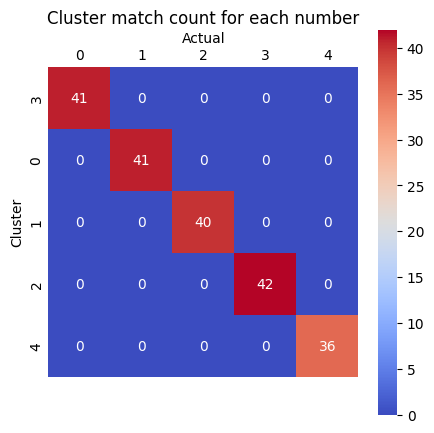

Purity  1.0


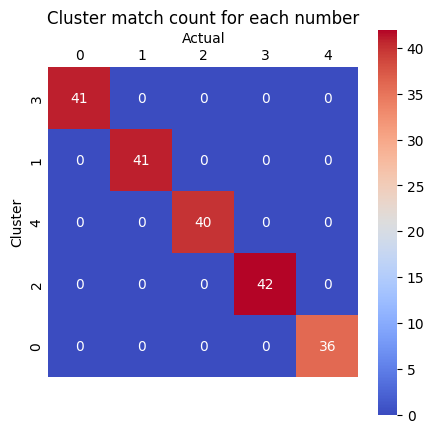

In [187]:
model = train(features, adj)

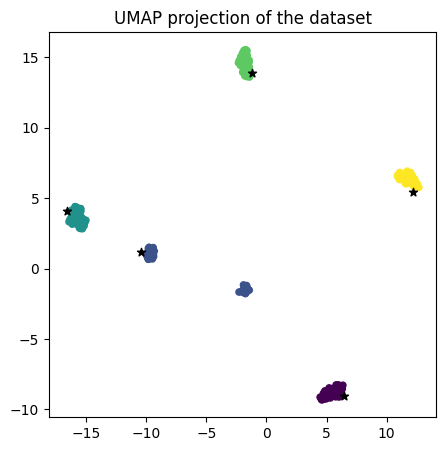

In [46]:
model.eval()
_, encoded_data, clusting_pred = model(features, 500)
encoded = encoded_data.cpu().detach().numpy()
centroids = model.cluster_centroid.cpu().detach().numpy()
umap_visualize(0, encoded, color = clusters, centroids = centroids)
# TSNE_visualize(0, encoded, color = clusters, centroids = centroids)
# TSNE_visualize(0, encoded, color = clusting_pred, centroids = centroids)

In [47]:
clusting_pred

tensor([[2.1061e-01, 2.7074e-01, 5.0610e-01, 1.2555e-02, 0.0000e+00],
        [2.1277e-01, 2.6783e-01, 5.1830e-01, 1.1007e-03, 0.0000e+00],
        [1.9946e-01, 2.8276e-01, 5.1068e-01, 7.1027e-03, 0.0000e+00],
        [2.1096e-01, 2.7188e-01, 5.0753e-01, 9.6242e-03, 0.0000e+00],
        [2.0491e-01, 2.7407e-01, 5.0999e-01, 1.1035e-02, 0.0000e+00],
        [2.0943e-01, 2.6823e-01, 5.0541e-01, 1.6931e-02, 0.0000e+00],
        [2.4164e-01, 2.6249e-01, 4.9081e-01, 0.0000e+00, 5.0564e-03],
        [2.0264e-01, 2.7490e-01, 5.1186e-01, 1.0604e-02, 0.0000e+00],
        [2.0787e-01, 2.7468e-01, 5.0709e-01, 1.0360e-02, 0.0000e+00],
        [2.0457e-01, 2.7401e-01, 5.0876e-01, 1.2660e-02, 0.0000e+00],
        [2.0106e-01, 2.7540e-01, 5.1342e-01, 1.0130e-02, 0.0000e+00],
        [2.4225e-01, 2.6156e-01, 4.9552e-01, 0.0000e+00, 6.7004e-04],
        [2.1897e-01, 2.5840e-01, 5.1352e-01, 9.1059e-03, 0.0000e+00],
        [2.1500e-01, 2.6306e-01, 5.0465e-01, 1.7300e-02, 0.0000e+00],
        [2.5831e-01,

#### Collaboration between group 1 & 2

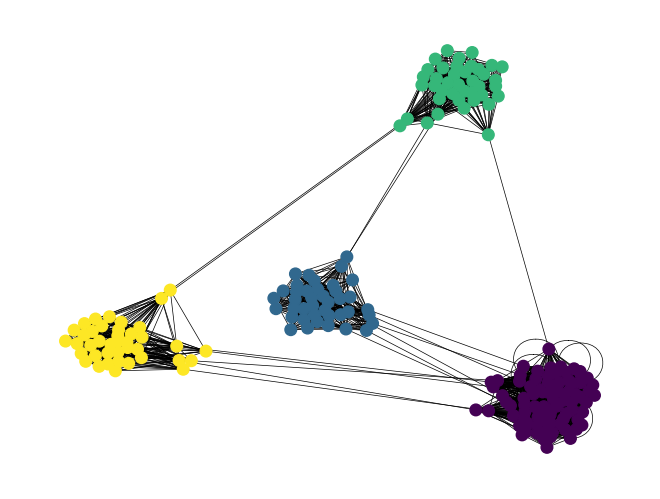

In [53]:
# edges_btw_clusters
for i in range(200):
    idx_i = np.random.randint(0, 2 * 40)
    idx_j = np.random.randint(0, 2 * 40)
    g.add_edge(idx_i,idx_j,weight = 1)
com = louvain(g)
visualization(g,com)

/tmp/ipykernel_4479/2904529294.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj2 = sp.coo_matrix(nx.adjacency_matrix(g))


Epoch: 0001 train_loss= 0.67260 mf_loss= 0.67260 train_acc= 0.12957 time= 0.02729
Epoch: 0002 train_loss= 0.62257 mf_loss= 0.62257 train_acc= 0.19222 time= 0.01722
Epoch: 0003 train_loss= 0.59193 mf_loss= 0.59193 train_acc= 0.33103 time= 0.01111
Epoch: 0004 train_loss= 0.57552 mf_loss= 0.57552 train_acc= 0.45998 time= 0.00252
Epoch: 0005 train_loss= 0.56642 mf_loss= 0.56642 train_acc= 0.60032 time= 0.00214
Epoch: 0006 train_loss= 0.56176 mf_loss= 0.56176 train_acc= 0.69563 time= 0.00840
Epoch: 0007 train_loss= 0.55930 mf_loss= 0.55930 train_acc= 0.75797 time= 0.00290
Epoch: 0008 train_loss= 0.55793 mf_loss= 0.55793 train_acc= 0.79908 time= 0.01314
Epoch: 0009 train_loss= 0.55716 mf_loss= 0.55716 train_acc= 0.82152 time= 0.00311
Epoch: 0010 train_loss= 0.55667 mf_loss= 0.55667 train_acc= 0.83197 time= 0.00220
Epoch: 0011 train_loss= 0.55635 mf_loss= 0.55635 train_acc= 0.83852 time= 0.00212
Epoch: 0012 train_loss= 0.55612 mf_loss= 0.55612 train_acc= 0.84048 time= 0.00207
Epoch: 0013 trai

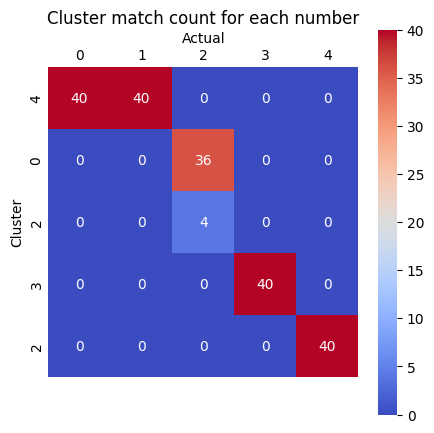

Purity  0.8


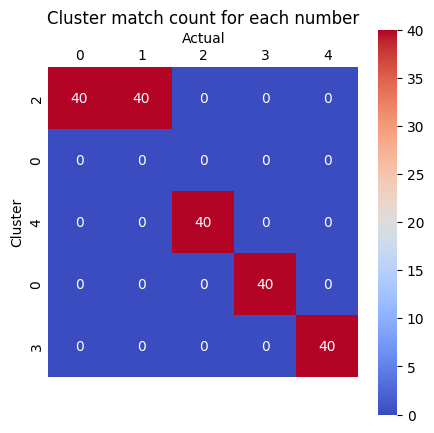

In [54]:
adj2 = sp.coo_matrix(nx.adjacency_matrix(g))
features2 = sp.coo_matrix(np.eye(adj2.shape[0]), dtype=np.int64)  # use one hot as features
features2 = sparse_to_tuple(features2.tocoo())
features2 = torch.sparse.FloatTensor(torch.LongTensor(features2[0].T),
                                        torch.FloatTensor(features2[1]),
                                        torch.Size(features2[2]))
model2 = train(features2, adj2)                                        

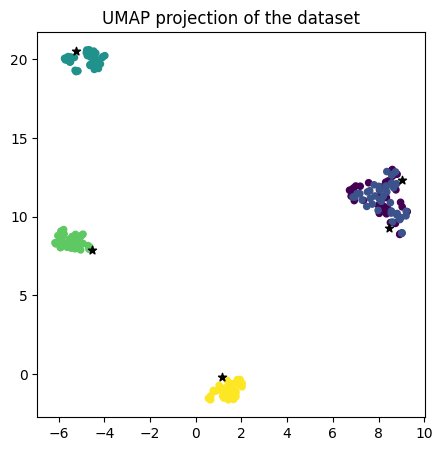

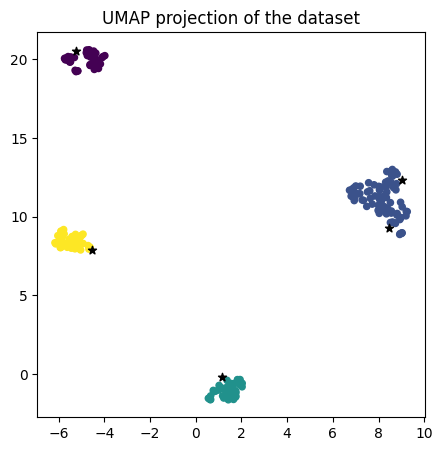

In [55]:
model2.eval()
_, encoded_data, clusting_pred = model2(features2, 1000)
encoded = encoded_data.cpu().detach().numpy()
centroids = model2.cluster_centroid.cpu().detach().numpy()
clusters_pred = clusting_pred.argmax(dim=1).cpu().detach().numpy()
umap_visualize(0, encoded, color = clusters, centroids = centroids)
umap_visualize(0, encoded, color = clusters_pred, centroids = centroids)
# TSNE_visualize(0, encoded, color = clusters, centroids = centroids)


In [56]:
model_copy = copy.deepcopy(model2)

### TOPO LOSS

In [57]:
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir="./runs/result_mf", flush_secs=120)

In [58]:
############################
# Vietoris-Rips filtration #
############################

# The parameters of the model are the point coordinates.

def wrcf(G:nx.Graph, weight="weight"): # networkx version
    """Compute the weight-rank clique filtration (WRCF) of a graph.
    :param G: networkx Graph
    :param weight: name of the weight attribute
    :return: a gudhi filtration.
    """
    # Define filtration step 0 as the set of all nodes
    st = gd.SimplexTree()
    for v in G.nodes():
        st.insert([v], filtration=0)
    # Rank all edge weights (from large to small)
    distinct_weights = np.unique([i[2] for i in G.edges.data("weight")])[::-1]
    for t, w in enumerate(distinct_weights):
    # At filtration step t, threshold the graph at weight[t]
        subg = G.edge_subgraph([(u,v) for u,v,_w, in G.edges.data("weight") if _w>=w])
        # Find all maximal cliques and define them to be simplices
        for clique in nx.find_cliques(subg):
            # st.insert(clique,filtration=t+1) # the version used in thesis
            st.insert(clique,filtration=1/w)
    return st

def WRCF_Index(G, dim, card):
    # Parameters: G (adjancy matrix), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi

    st = wrcf(nx.from_numpy_matrix(G))
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(G[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(G[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())  
    # [perm] sort, [::-1,:] reverse
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return np.array(indices, dtype=np.int32)

class WrcfLayer(torch.nn.Module):
    def __init__(self, dim=1, card=50):
        super(WrcfLayer, self).__init__()
        self.dim = dim
        self.card = card

    def forward(self, G:torch.Tensor):
        d, c = self.dim, self.card
        print(G)
        # Compute vertices associated to positive and negative simplices
        # Don't compute gradient for this operation
        with torch.no_grad():
            ids = torch.from_numpy(WRCF_Index(G.numpy(), d, c)) # from_numpy will keep dtype
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        if d > 0:
            indices = ids.view([2*c,2]).long() 
            dgm = G[indices[:,0], indices[:,1]].view(c, 2)
        else:
            indices = ids.view([2*c,2])[1::2,:].long()
            dgm = torch.cat([torch.zeros(c, 1), # birth will always be zero
                             G[indices[:,0], indices[:,1]].view(c, 1).float()], dim=1)
        return dgm

In [144]:
class WrcfGAE(torch.nn.Module):
    def __init__(self, adj, gae_model, ground_truth) -> None:
        super().__init__()
        self.gae = gae_model.cpu()
        self.wrcf = WrcfLayer(dim=0, card=20)
        self.adj = adj
        self.Q = None
        self.dgm_gt = self.wrcf(self.build_community_graph(*ground_truth))
        # print("ground truth C:",self.build_community_graph(*ground_truth))
        # print("ground truth dgm:", self.dgm_gt)
    
    def soft_argmax(x, dim, beta=1e2):
    # crude: assumes max value is unique
        xx = beta  * x
        sm = torch.nn.functional.softmax(xx, dim=dim)
        indices = torch.arange(x.size(dim))
        y = torch.mul(indices, sm)
        result = torch.sum(y,dim=dim)
        return result

    def build_community_graph(self, Q:torch.tensor, W:sp.coo_matrix):
        # Q : the indicator matrix
        # W : the weighted graph adj matrix
        indicator = torch.argmax(Q, dim=1)
        # indicator = self.soft_argmax(Q, dim=1)
        indicator_hat = torch.stack([torch.where(indicator == k, 1, 0.) for k in range(Q.size(1))]).T
        Q_hat = indicator_hat * Q
        W = torch.tensor(W.todense(),dtype=torch.float)
        result = torch.mm(torch.mm(Q_hat.T, W), Q_hat).fill_diagonal_(0)
        result = result / W.sum() # Normalization
        return result


    def forward(self, features, epoch, adj_label, weight_tensor, norm):

        A_pred, encoded_z, dict_s = self.gae(features, epoch + args.start_mf +1)
        re_loss = norm * F.binary_cross_entropy(A_pred.view(-1),
                                                adj_label.to_dense().view(-1),
                                                weight=weight_tensor)

        loss_cm = torch.nn.MSELoss()
        loss_kmeans = loss_cm(encoded_z, torch.mm(dict_s, self.gae.cluster_centroid))

        
        # compute graph filtration based topological loss
        C = self.build_community_graph(dict_s, self.adj)
        dgm = self.wrcf(C)
        # loss_topo = torch.square(wasserstein_distance(dgm, self.dgm_gt, order=2, 
        #                 enable_autodiff=True, keep_essential_parts=False))

        loss_topo = wasserstein_distance(dgm, self.dgm_gt, order=1, internal_p=2,
                        enable_autodiff=True, keep_essential_parts=False)
        loss = 1*re_loss + 1*loss_topo 
        # writer.add_scalar('Loss/topo-0.1',loss_topo.item(),global_step=epoch)


        # print acc and loss
        train_acc = get_acc(A_pred, adj_label)
        print("Epoch:", '%04d' % (epoch + 1), "cluster_loss=", "{:.5f}".format(loss_kmeans.item()),
            "topo_loss=", "{:.5f}".format(loss_topo.item()),
            "train_acc=", "{:.5f}".format(train_acc))
        return loss


In [145]:
def retrain_with_topo(_model,gt_output,adj,features):
    adj_norm = preprocess_graph(adj) # norm
    adj_label = sparse_to_tuple(adj)

    adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                        torch.FloatTensor(adj_norm[1]),
                                        torch.Size(adj_norm[2])).cpu()
    adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                        torch.FloatTensor(adj_label[1]),
                                        torch.Size(adj_label[2])).cpu()

    # add weight on edges (<1> class) to avoid sparse graph caused unbalance classification
    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    weight_mask = adj_label.to_dense().view(-1) == 1
    weight_tensor = torch.ones(weight_mask.size(0))
    weight_tensor[weight_mask] = pos_weight

    # train model
    whole_model = WrcfGAE(adj, gae_model=_model,ground_truth=gt_output)
    optimizer = torch.optim.Adam(whole_model.parameters(), lr=0.01)

    
    for epoch in range(100):
        optimizer.zero_grad()
        # TOPO LOSS
        loss = whole_model(features.cpu(), epoch, adj_label, weight_tensor, norm)
        loss.backward()
        optimizer.step()

In [146]:
model2 = copy.deepcopy(model_copy)
with torch.no_grad():
    _, Z_GT, Q_GT = model(features, _epoch=1000)
retrain_with_topo(model2,[Q_GT, adj],adj2,features2)

tensor([[0.0000e+00, 0.0000e+00, 2.5732e-04, 2.3411e-04, 2.0068e-04],
        [0.0000e+00, 0.0000e+00, 2.3888e-04, 2.2299e-04, 2.8385e-04],
        [2.5732e-04, 2.3888e-04, 0.0000e+00, 9.1207e-05, 0.0000e+00],
        [2.3411e-04, 2.2299e-04, 9.1207e-05, 0.0000e+00, 0.0000e+00],
        [2.0068e-04, 2.8385e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[0.0000e+00, 6.9331e-05, 2.3432e-04, 0.0000e+00, 1.7842e-04],
        [6.9331e-05, 0.0000e+00, 5.1261e-04, 0.0000e+00, 3.0256e-04],
        [2.3432e-04, 5.1261e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7842e-04, 3.0256e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       grad_fn=<DivBackward0>)
Epoch: 0001 cluster_loss= 0.00004 topo_loss= 0.00044 train_acc= 0.84123
tensor([[0.0000e+00, 5.3629e-05, 6.8841e-05, 0.0000e+00, 8.4417e-05],
        [5.3629e-05, 0.0000e+00, 2.8006e-04, 2.1649e-03, 1.1791e-04],
        [6.8841e-05, 2.8006e-04, 0.0000e+00, 0.0000e+00

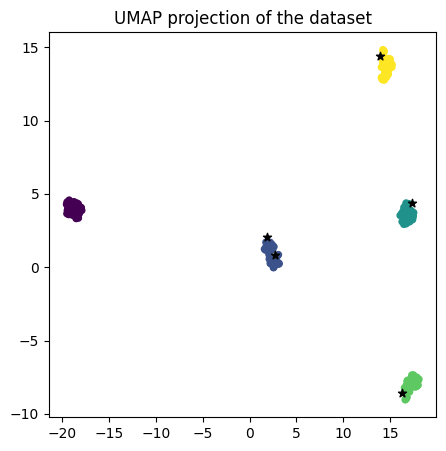

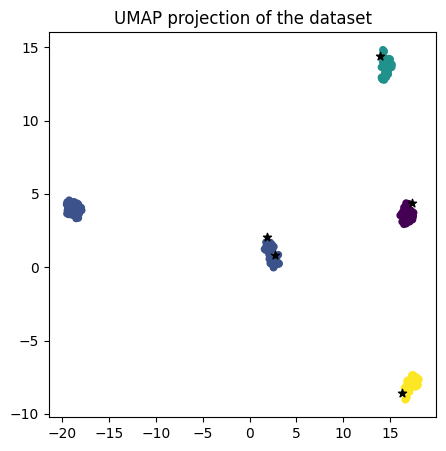

/home/dexu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


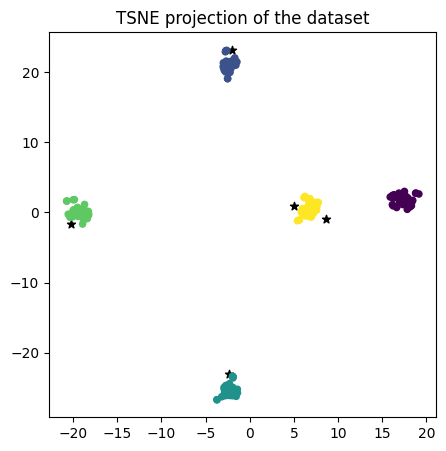

In [147]:
model2.eval()
_, encoded_data, clusting_pred = model2(features2, 1000)
encoded = encoded_data.cpu().detach().numpy()
centroids = model2.cluster_centroid.cpu().detach().numpy()
clusters_pred = clusting_pred.argmax(dim=1).cpu().detach().numpy()

umap_visualize(0, encoded, color = clusters, centroids = centroids)
umap_visualize(0, encoded, color = clusters_pred, centroids = centroids)
# TSNE_visualize(0, encoded, color = clusters, centroids = centroids)

k_encoded = KMeans(n_clusters=args.n_cluster)
k_encoded.fit(encoded)
TSNE_visualize(0, encoded, color = k_encoded.labels_, centroids = centroids)

Purity  1.0


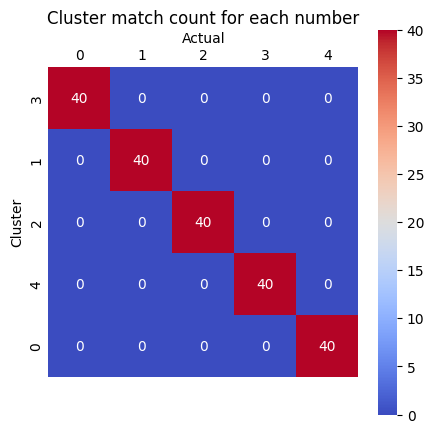

Purity  0.8


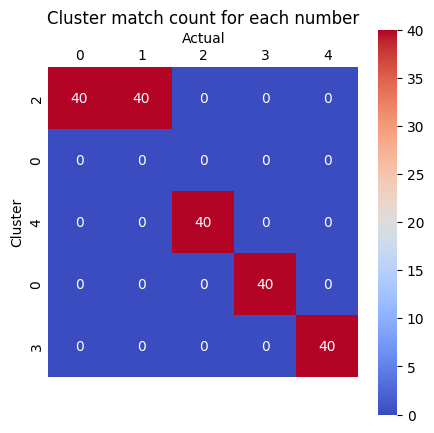

In [148]:
kmeans(encoded_data, labels=clusters, indicators=clusting_pred, n_clusters=args.n_cluster)